<a href="https://colab.research.google.com/github/LittleAri/egg_cards/blob/main/egg_cards_box_alignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Egg Card Alignment Tests

Testing out BS's box alignment code, as pre-processing step for layout parser and further OCR.

#### Installs

In [ ]:
!pip install deskew

#### Imports

In [ ]:
from skimage.color import rgb2gray
from skimage.transform import rotate
from deskew import determine_skew
from matplotlib import pyplot as plt
import cv2
import matplotlib
%matplotlib inline
import numpy as np
from copy import deepcopy
import os

#### Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image_path = 'drive/My Drive/egg_cards/drawer_1/001-0626.jpg'
image = cv2.imread(image_path)

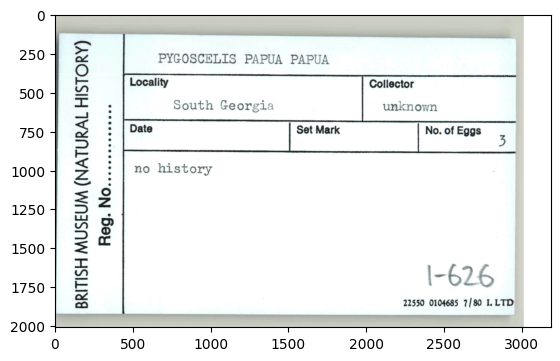

In [ ]:
plt.imshow(image)

#### Threshold & Box Contour Extraction

In [ ]:
grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(grey, 100, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

In [ ]:
contours, hierarchy  = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_flat = np.vstack(contours).squeeze()
rect = cv2.minAreaRect(contours_flat)

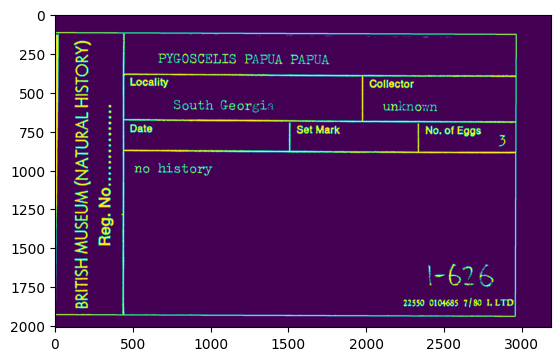

In [ ]:
box = cv2.boxPoints(rect) # cv2.boxPoints(rect) for OpenCV 3.x
box = np.int0(box)
cv2.drawContours(thresh,[box],0,(255,255,0),5)

plt.imshow(thresh)

#### Angle Detection
(Ben's code)

In [ ]:
# https://pyimagesearch.com/2016/03/21/ordering-coordinates-clockwise-with-python-and-opencv/

def get_angle_point(rect):
    """
    The point the minAreaRect is calculate from is lowest Y

    """

    box = cv2.boxPoints(rect)
    box = np.int0(box)

#     box_sum = box.sum(axis=1)
#     box_diff = np.diff(box, axis=1)

#     # bottom-right point will have the largest sum
#     bottom_right  = box[np.argmax(box_sum)]
#     # bottom-left will have the largest difference
#     bottom_left = box[np.argmax(box_diff)]

#     print(bottom_left)
#     print(bottom_right)


    # Get the largest y (lowest
    bottom_points = box[box[:, 1].argsort()][2:]

    # Get the lowest point (max y - counts from the top)
    min_y_point = bottom_points[np.where(bottom_points[:, 1] == np.max(bottom_points[:, 1]))]

    # If there's two points, x max
    if len(min_y_point) == 2:
        return bottom_points[np.argmax(bottom_points[:, 0])]
    else:
        return min_y_point.squeeze()

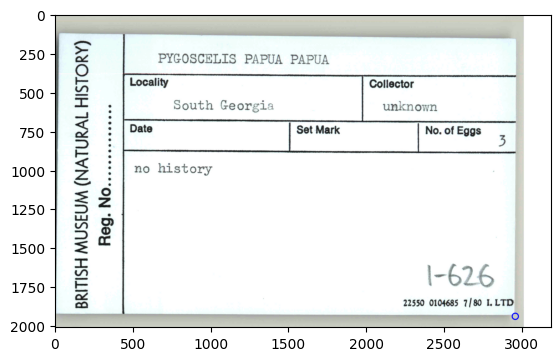

In [ ]:
point = get_angle_point(rect)

img = cv2.circle(image, point, 20, color=(0, 0, 255), thickness=5)

plt.imshow(img)

#### Image Rotation
(Ben's code)

In [ ]:
center, width_height, angle = rect

In [ ]:
# If the point to which the angle is calculate is the bottom left,
if point[0] < center[0]:
    angle = angle - 90

print(angle)
(h, w) = img.shape[:2]
center = (w // 2, h // 2)

M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

0.21018166840076447


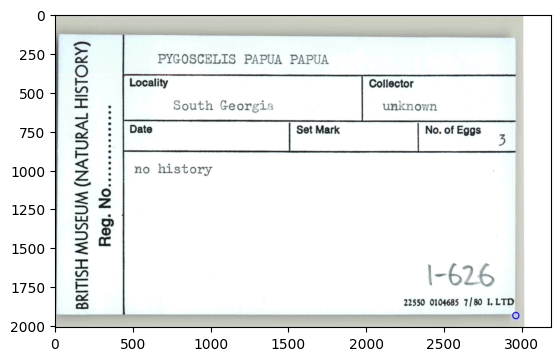

In [ ]:
plt.imshow(rotated)

#### All-in-one Rotation Function

In [ ]:
def rotate_image(original_image):
  image = deepcopy(original_image)
  # 1) Threshold image
  grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  thresh = cv2.threshold(grey, 100, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
  # 2) Find contour around card:
  contours, _  = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours_flat = np.vstack(contours).squeeze()
  rect = cv2.minAreaRect(contours_flat)
  box = cv2.boxPoints(rect) # cv2.boxPoints(rect) for OpenCV 3.x
  box = np.int0(box)
  # 3) Get angle axis point:
  point = get_angle_point(rect)
  # 4) Compute rotation matrix:
  center, width_height, angle = rect
  # If the point to which the angle is calculate is the bottom left,
  if point[0] < center[0]:
      angle = angle - 90
  (h, w) = image.shape[:2]
  center = (w // 2, h // 2)
  M = cv2.getRotationMatrix2D(center, angle, 1.0)
  # 5) Rotate image:
  rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
  return rotated

#### Examples

In [ ]:
folder_path = 'drive/My Drive/egg_cards/drawer_1/'
drawer_1_sample = os.listdir(folder_path)

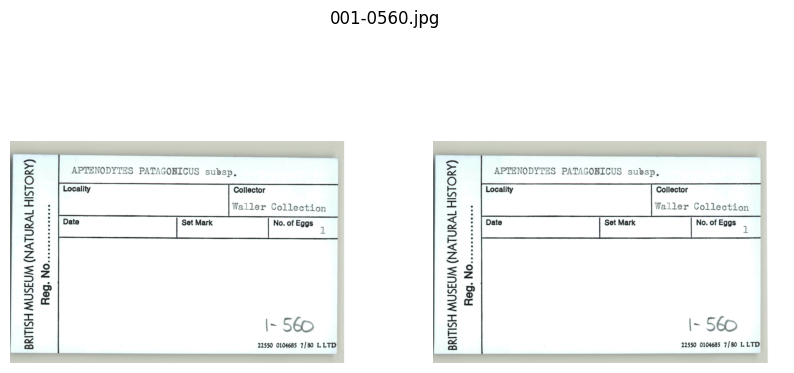

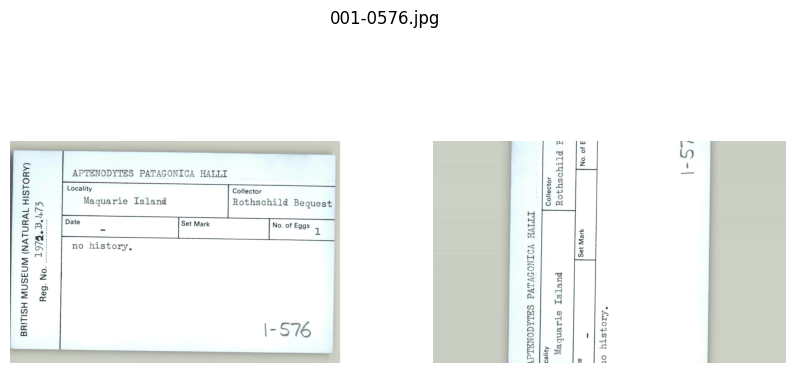

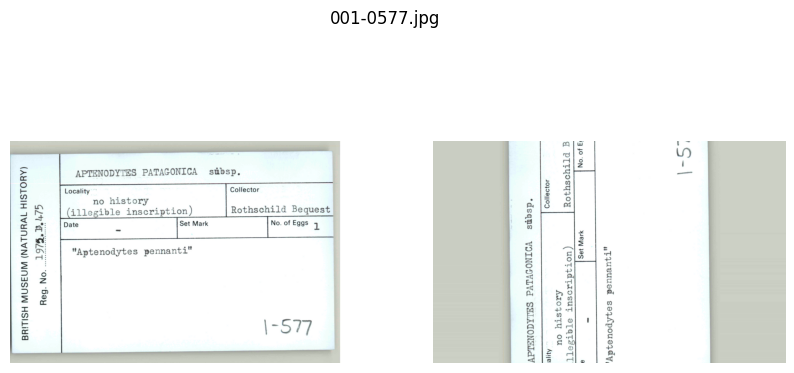

In [ ]:
for file in drawer_1_sample[:3]:
  image_path = folder_path+file
  image = cv2.imread(image_path)
  rotated_image = rotate_image(image)
  fig,ax = plt.subplots(1,2,figsize=(10,5))
  ax[0].imshow(image)
  ax[1].imshow(rotated_image)
  ax[0].axis('off')
  ax[1].axis('off')
  plt.suptitle(str(file))